In [ ]:
pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 63% 51.0M/80.9M [00:00<00:00, 534MB/s]
100% 80.9M/80.9M [00:00<00:00, 608MB/s]


In [ ]:
#extracting the comptessed zipfile
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset is extracted")


The dataset is extracted


In [ ]:
#importing the dependencies
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:
#Data Processing
twitterData = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding= 'ISO-8859-1')


In [ ]:
#checking rows and cols
twitterData.shape

(1599999, 6)

In [ ]:
twitterData.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
columnNames = ['target','ID','date','flag','user','text']
twitterData = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names = columnNames, encoding= 'ISO-8859-1')
twitterData.head()

,target,ID,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
#counting null values
twitterData.isnull().sum()

,0
target,0
ID,0
date,0
flag,0
user,0
text,0


In [ ]:
#checking the distribution of target column
twitterData['target'].value_counts()

,count
target,
0,800000
4,800000


In [ ]:
  #rewriting target 4 as 1
  twitterData.replace({'target':{4:1}}, inplace = True)
  twitterData['target'].value_counts()

,count
target,
0,800000
1,800000


In [ ]:
#Stemming
#It is a process of reducing a word to its Root Word
#ex: actor, actress, acting = act
port_stem = PorterStemmer()

In [ ]:
def stemming(content):

  stemmed_content = re.sub('[^a-zA-Z]',' ',content) #removes all elements except alphabets
  stemmed_content = stemmed_content.lower() #convert to lowercase
  stemmed_content = stemmed_content.split() #split each word individually
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')] #To check if the word doesn't belong to stopword
  stemmed_content = ' '.join(stemmed_content) #join the non stopword words

  return stemmed_content

In [ ]:
twitterData['stemmed_content'] = twitterData['text'].apply(stemming)

In [ ]:
twitterData.head()


,target,ID,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [ ]:
print(twitterData['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [ ]:
print(twitterData['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [ ]:
X = twitterData['stemmed_content'].values
Y = twitterData['target'].values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [ ]:
#Converting the textual data to numerical data
vectorizer = TfidfVectorizer()


X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9453092 stored elements and shape (1280000, 461488)>
  Coords	Values
  (0, 436713)	0.27259876264838384
  (0, 354543)	0.3588091611460021
  (0, 185193)	0.5277679060576009
  (0, 109306)	0.3753708587402299
  (0, 235045)	0.41996827700291095
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 109306)	0.4591176413728317
  (2, 124484)	0.1892155960801415
  (2, 407301)	0.18709338684973031
  (2, 129411)	0.29074192727957143
  (2, 406399)	0.32105459490875526
  (2, 433560)	0.3296595898028565
  (2, 77929)	0.31284080750346344
  (2, 443430)	0.3348599670252845
  (2, 266729)	0.24123230668976975
  (2, 409143)	0.15169282335109835
  (2, 178061)	0.1619010109445149
  (2, 150715)	0.18803850583207948
  (2, 132311)	0.2028971570399794
  (2, 288470)	0.16786949597862733
  (3, 406399)	0.29029991238662284
  (3, 158711)	0.4456939372299574
  (3, 151770)	0.278559647704793
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 318303)	0.21254698865277744
  (12

In [ ]:
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2289192 stored elements and shape (320000, 461488)>
  Coords	Values
  (0, 15110)	0.1719352837797837
  (0, 31168)	0.1624772418052177
  (0, 67828)	0.26800375270827315
  (0, 106069)	0.36555450010904555
  (0, 132364)	0.255254889555786
  (0, 138164)	0.23688292264071406
  (0, 171378)	0.2805816206356074
  (0, 271016)	0.45356623916588285
  (0, 279082)	0.17825180109103442
  (0, 388348)	0.2198507607206174
  (0, 398906)	0.34910438732642673
  (0, 409143)	0.3143047059807971
  (0, 420984)	0.17915624523539805
  (1, 6463)	0.30733520460524466
  (1, 15110)	0.211037449588008
  (1, 145393)	0.575262969264869
  (1, 217562)	0.40288153995289894
  (1, 256777)	0.28751585696559306
  (1, 348135)	0.4739279595416274
  (1, 366203)	0.24595562404108307
  (2, 22532)	0.3532582957477176
  (2, 34401)	0.37916255084357414
  (2, 89448)	0.36340369428387626
  (2, 183312)	0.5892069252021465
  (2, 256834)	0.2564939661498776
  :	:
  (319994, 443794)	0.2782185641032538


In [ ]:
#Training the ML Model LOGISTIC REGRESSION

model = LogisticRegression(max_iter=1000)


In [ ]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [ ]:
#Model Evaluation (Accuracy Score)
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)

In [ ]:
print(training_data_accuracy)

0.79871953125


In [ ]:
#Model Evaluation Test Data (Accuracy Score)
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)

In [ ]:
print(test_data_accuracy)

0.77668125


In [ ]:
#Saving the trained model
import pickle
fileName = 'trained_model.sav'
pickle.dump(model, open(fileName, 'wb'))

In [ ]:
loaded_model = pickle.load(open('/content/trained_model.sav', 'rb'))

In [ ]:
index = 200
X_new = X_test[index]
print(Y_test[index])

prediction = model.predict(X_new)
print(prediction)
if(prediction[0] == 0):
  print('Negetive Tweet')
else:
  print('Positive Tweet')


1
[1]
Positive Tweet


In [ ]:
index = 3
X_new = X_test[index]
print(Y_test[index])

prediction = model.predict(X_new)
print(prediction)
if(prediction[0] == 0):
  print('Negetive Tweet')
else:
  print('Positive Tweet')


0
[0]
Negetive Tweet


In [ ]:
import os
os.makedirs("models", exist_ok=True)  # makes folder if it doesn’t already exist


In [ ]:
# 0. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# 1. Load data (same file you already download)
COLS = ['target','id','date','flag','user','text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=COLS, header=None)
df = df[['target','text']].dropna()
df['target'] = df['target'].replace({4:1})  # 0=negative, 1=positive

# (Optional: small sample to iterate faster during development)
# df = df.sample(200_000, random_state=42)

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'].values, df['target'].values,
    test_size=0.2, stratify=df['target'], random_state=42
)

# 3. Build pipeline (vectorizer + classifier)
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True
    )),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

# 4. Train
pipe.fit(X_train, y_train)

# 5. Evaluate
pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=4))

# 6. Save ENTIRE pipeline
joblib.dump(pipe, 'models/baseline_pipeline.joblib')  # create /models folder first if needed


Accuracy: 0.7916
              precision    recall  f1-score   support

           0     0.8030    0.7728    0.7876    160000
           1     0.7810    0.8104    0.7955    160000

    accuracy                         0.7916    320000
   macro avg     0.7920    0.7916    0.7915    320000
weighted avg     0.7920    0.7916    0.7915    320000



['models/baseline_pipeline.joblib']

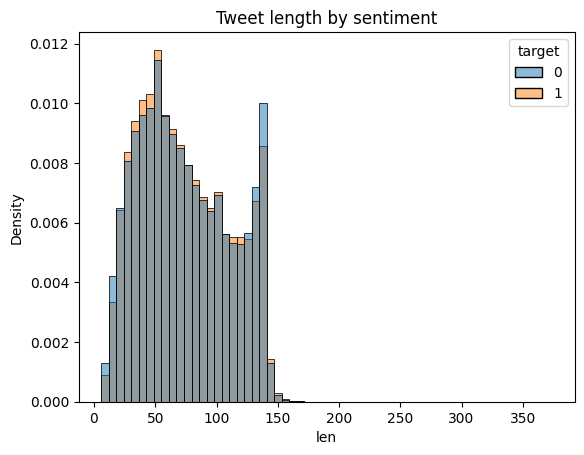

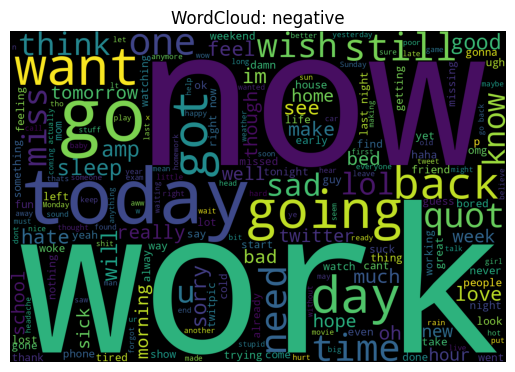

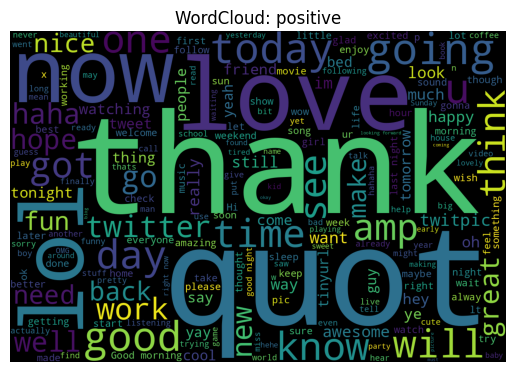

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns
from wordcloud import WordCloud

df['len'] = df['text'].str.len()
sns.histplot(df, x='len', hue='target', bins=60, stat='density', common_norm=False)
plt.title('Tweet length by sentiment'); plt.show()

for label,name in [(0,'negative'),(1,'positive')]:
    text_blob = " ".join(df.loc[df['target']==label,'text'].astype(str).tolist()[:100000])
    wc = WordCloud(width=1200, height=800).generate(text_blob)
    plt.imshow(wc); plt.axis('off'); plt.title(f'WordCloud: {name}'); plt.show()


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

def make_pipe(clf):
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            lowercase=True, stop_words='english',
            ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True)),
        ('clf', clf)
    ])

candidates = {
    'logreg': (LogisticRegression(max_iter=2000, class_weight='balanced'), {'clf__C':[0.5,1,2]}),
    'linsvc': (LinearSVC(class_weight='balanced'), {'clf__C':[0.5,1,2]}),
    'bnb':    (BernoulliNB(), {'clf__alpha':[0.1,0.5,1.0]}),
}

best_est=None; best_name=None; best_cv=-1
for name,(clf,grid) in candidates.items():
    pipe = make_pipe(clf)
    gs = GridSearchCV(pipe, grid, cv=3, n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    print(f"[{name}] best cv {gs.best_score_:.4f} | params {gs.best_params_}")
    ypred = gs.best_estimator_.predict(X_test)
    print(f"[{name}] test report:\n", classification_report(y_test, ypred, digits=4))
    if gs.best_score_ > best_cv:
        best_cv = gs.best_score_; best_est = gs.best_estimator_; best_name = name

print("Chosen model:", best_name)
joblib.dump(best_est, 'models/baseline_pipeline.joblib')


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[logreg] best cv 0.7877 | params {'clf__C': 2}
[logreg] test report:
               precision    recall  f1-score   support

           0     0.8017    0.7737    0.7875    160000
           1     0.7814    0.8087    0.7948    160000

    accuracy                         0.7912    320000
   macro avg     0.7916    0.7912    0.7911    320000
weighted avg     0.7916    0.7912    0.7911    320000

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[linsvc] best cv 0.7810 | params {'clf__C': 0.5}
[linsvc] test report:
               precision    recall  f1-score   support

           0     0.7944    0.7682    0.7811    160000
           1     0.7756    0.8011    0.7882    160000

    accuracy                         0.7847    320000
   macro avg     0.7850    0.7847    0.7846    320000
weighted avg     0.7850    0.7847    0.7846    320000

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[bnb] best cv 0.7741 | para

['models/baseline_pipeline.joblib']

In [ ]:
import json
from sklearn.metrics import confusion_matrix

best = joblib.load('models/baseline_pipeline.joblib')
yhat = best.predict(X_test)

cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix'); plt.xlabel('Pred'); plt.ylabel('True')
plt.savefig('baseline_confusion_matrix.png', dpi=180); plt.close()

rep = classification_report(y_test, yhat, digits=4, output_dict=True)
with open('baseline_metrics.json','w') as f:
    json.dump(rep, f, indent=2)


In [ ]:
import pandas as pd
pipe = joblib.load('models/baseline_pipeline.joblib')
vec = pipe.named_steps['tfidf']
clf = pipe.named_steps['clf']
Xt = vec.transform(X_test)
# Works for LinearSVC/LogReg:
scores = getattr(clf, "decision_function", None)
if scores is not None:
    s = scores(Xt)
    margin = s if s.ndim==1 else s[:,1]
else:
    # fallback: predict_proba if available
    margin = clf.predict_proba(Xt)[:,1]

preds = pipe.predict(X_test)
wrong = preds != y_test
err = pd.DataFrame({'text': X_test[wrong], 'true': y_test[wrong], 'pred': preds[wrong], 'margin': margin[wrong]})
err.sort_values('margin', ascending=False).head(100).to_csv('error_examples.csv', index=False)


In [ ]:
import os, joblib

# make sure models folder exists
os.makedirs("models", exist_ok=True)

# save the entire pipeline (TF-IDF + classifier)
joblib.dump(pipe, "models/baseline_pipeline.joblib")


['models/baseline_pipeline.joblib']

In [ ]:
import sklearn, joblib, pandas, numpy
print("sklearn", sklearn.__version__)
print("joblib", joblib.__version__)
print("pandas", pandas.__version__)
print("numpy", numpy.__version__)


sklearn 1.6.1
joblib 1.5.1
pandas 2.2.2
numpy 2.0.2


In [ ]:
loaded_pipe = joblib.load("models/baseline_pipeline.joblib")

print(loaded_pipe.predict(["I love this phone!"]))
print(loaded_pipe.predict(["This is terrible."]))


[1]
[0]


In [ ]:
from google.colab import files
files.download("models/baseline_pipeline.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>